## CHEME 5660: Testing our Trade Bot Policy against Historical Price Data

### Introduction
Let's evaluate the policy estimated from the [Q-learning approach](https://varnerlab.github.io/CHEME-5660-Markets-Mayhem-Book/chapter-4-dir/rl.html#q-learning). In particular, let's implement the proposed policy for some tickers on the `5 min` portfolio data set and look at the portfolio size and average share cost.

### Setup

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-Q-Learning-TradeBot-notebook`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-Q-Learning-TradeBot-notebook/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-Q-Learning-TradeBot-notebook/Manifest.toml`


In [2]:
# load req packages -
using DataFrames
using Dates
using FileIO
using JLD2
using PrettyTables
using Distributions
using Statistics
using DataFrames
using Plots
using Colors
using MLJLinearModels
using StatsPlots

# setup paths -
const _ROOT = pwd();
const _PATH_TO_DATA = joinpath(_ROOT, "data");

In [3]:
include("CHEME-5660-Example-CodeLib.jl");

In [4]:
# what ticker do we want to explore?
ticker_symbol = "NOC";

In [5]:
# load the JLD2 portfolio data file -
price_data_dictionary = load(joinpath(_PATH_TO_DATA, "CHEME-5660-Portfolio-Q-learning-5min-11-20-22.jld2"))["dd"];

# get ticker price data -
df_test = price_data_dictionary[ticker_symbol];

# load the policy data file -
policy_model = load(joinpath(_PATH_TO_DATA,"Policy-$(ticker_symbol)-Model-T1000-IC-EXPERT.jld2"))["model"];
W = policy_model.W;
policy = policy_model.policy;
Sₒ = policy_model.Sₒ;
σ̂ = policy_model.σ̂;
δ = policy_model.δ

# what is my trade size?
nₒ = 500.0; # initially buy this many shares
nₐ = 1.0;   # any individual trade buy this many shares

In [6]:
policy

4-element Vector{Int64}:
 2
 2
 1
 3

In [7]:
# build account data frame -
account_df = DataFrame(
    time = DateTime[],
    size = Float64[],
    Δ = Float64[],
    action = Int64[],
    price = Float64[],
    avgcost = Float64[],
    cash = Float64[], 
    state = Int64[]
);

# grab an initial price - and record first trade 
initial_price = price(df_test,1);
record = (
    time = df_test[1,:timestamp],
    size = nₒ,
    Δ = nₒ,
    price = initial_price,
    avgcost = initial_price,
    action = 1,
    cash = 0.0,
    state = state(initial_price, W)
);
push!(account_df, record);

# how many trades do we have in our ledger?
number_of_trades = nrow(df_test);
for trade_index ∈ 2:number_of_trades
    
    # get the data for this trade -
    trade_date = df_test[trade_index,:timestamp];
    
    # compute my policy -
    p = price(df_test, trade_index); # get price
    s = state(p, W); # classify this price
    aᵢ = policy[s]; # get the action -
    
    # compute the cumulative number of shares we own -
    current_account_size = account_df[trade_index-1,:size];
    if (aᵢ == 1)  # buy
        
        # compute the current number of shares and (before this action)
        new_account_size = current_account_size + nₐ;
        
        # record -
        record = (
            time = trade_date,
            size = new_account_size,
            Δ = nₐ,
            price = p,
            action = aᵢ,
            avgcost = 0.0,
            cash = 0.0,
            state = s
        );
        push!(account_df, record);
        
    elseif (aᵢ == 2 && current_account_size > (nₐ + 1)) # sell
        
        # compute the current number of shares and (before this action)
        new_account_size = current_account_size - nₐ;
        
        # record -
        record = (
            time = trade_date,
            size = new_account_size,
            Δ = nₐ,
            price = p,
            action = aᵢ,
            avgcost = 0.0,
            cash = 0.0, 
            state = s
        );
        push!(account_df, record);
        
    elseif (aᵢ == 2 && current_account_size <= (nₐ+1))
        
        # we want to maintain at least 10 shares - override the recommended action
        new_account_size = current_account_size + nₐ;
    
        # record -
        record = (
            time = trade_date,
            size = new_account_size,
            Δ = nₐ,
            price = p,
            action = 1, # we buy - ovveride policy
            avgcost = 0.0,
            cash = 0.0, 
            state = s
        );
        push!(account_df, record);
    
    elseif (aᵢ == 3)
        
        # record -
        record = (
            time = trade_date,
            size = current_account_size,
            Δ = 0,
            price = p,
            action = aᵢ,
            avgcost = 0.0,
            cash = 0.0,
            state = s
        );
        push!(account_df, record);
    end
end

# compute the average price -
for trade_index ∈ 1:number_of_trades
    
    # compute the average price -
    avgcost = compute_average_cost(account_df[1:trade_index,:]);
    
    # set -
    account_df[trade_index,:avgcost] = avgcost;
end

In [8]:
account_df[1:20,:]

Row,time,size,Δ,action,price,avgcost,cash,state
,DateTime,Float64,Float64,Int64,Float64,Float64,Float64,Int64
1,2022-11-14T12:20:00,500.0,500.0,1,495.4,495.4,0.0,3
2,2022-11-14T12:35:00,501.0,1.0,1,495.4,495.4,0.0,3
3,2022-11-14T13:30:00,502.0,1.0,1,495.4,495.4,0.0,3
4,2022-11-14T13:35:00,503.0,1.0,1,495.4,495.4,0.0,3
5,2022-11-14T14:30:00,504.0,1.0,1,495.956,495.401,0.0,3
6,2022-11-14T14:35:00,505.0,1.0,1,498.057,495.406,0.0,3
7,2022-11-14T14:40:00,506.0,1.0,1,497.944,495.411,0.0,3
8,2022-11-14T14:45:00,506.0,0.0,3,493.888,495.411,0.0,4
9,2022-11-14T14:50:00,506.0,0.0,3,493.238,495.411,0.0,4


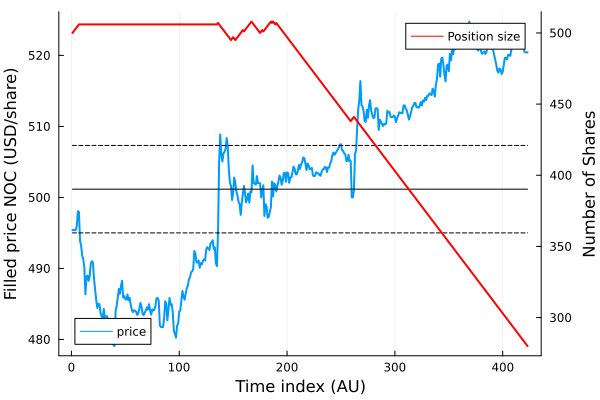

In [9]:
plot(account_df[:,:price], lw=2, ylabel="Filled price $(ticker_symbol) (USD/share)", xlabel="Time index (AU)", label="price", legend=:bottomleft)
plot!(twinx(), account_df[:,:size], c=:red, lw=2, ylabel="Number of Shares", label="Position size")
plot!(Sₒ*ones(number_of_trades), c=:black, label="")
plot!((Sₒ+δ*σ̂)*ones(number_of_trades), ls=:dash, c=:black, label="")
plot!((Sₒ-δ*σ̂)*ones(number_of_trades), ls=:dash, c=:black, label="")

### Disclaimer and Risks
__This content is offered solely for training and  informational purposes__. No offer or solicitation to buy or sell securities or derivative products, or any investment or trading advice or strategy,  is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on your evaluation of your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.